In [ ]:
%tensorflow_version 1.x

!nvcc --version
!nvidia-smi
import numpy as np
import os
import tensorflow as tf

print(tf.test.gpu_device_name())
import seaborn as sns
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D, InputLayer, Reshape, GlobalAveragePooling2D, Dropout, GlobalMaxPool2D
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile
from keras import Model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import scipy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
import pprint  # for pretty printing our device stats
from google.colab import files
print("Tensorflow version " + tf.__version__)


TensorFlow 1.x selected.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.


Tensorflow version 1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Connecting to Drive and Setting Up the Directory

In [ ]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#cd "drive/My Drive/MatlabSpectrogram"
%cd "gdrive/My Drive"


/content/gdrive/My Drive


# Function for creating models, getting data from drive by generators and training model

In [ ]:
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.regularizers import l1
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model, save_model
from sklearn.metrics import classification_report, confusion_matrix

#DataGenerators
train_datagen = ImageDataGenerator(
    rescale=1. / 255, width_shift_range=0.26, fill_mode="constant")
test_datagen = ImageDataGenerator(rescale=1. / 255)

#Reshape parameter
WINDOW = 224
 
#Create train and test data
def create_datagens(path, onlyTest=False, testAll=False,batch_size=64, printPath=True):
  
    stype = path.split("_",1)[1]
    save_path = "Models/FVA_" +stype +".h5"

    global checkpoint
    checkpoint = ModelCheckpoint(
      save_path,
      monitor='val_accuracy',
      verbose=1,
      save_best_only=True,
      mode='max',
      period=1)

    train = []
    if (not onlyTest):
        #Flow train data from rive
        train = train_datagen.flow_from_directory(
            directory=path + "/Train/",
            target_size=(WINDOW, WINDOW),
            batch_size=batch_size,
            class_mode="categorical")
        #Flow test data from rive
    newPath = path
    if (testAll):
        newPath = newPath.replace("123_8910", "all")
        newPath = newPath.replace("12_910", "all")
        newPath = newPath.replace("1_10", "all")
    test = test_datagen.flow_from_directory(
        directory=newPath + '/Test/',
        target_size=(WINDOW, WINDOW),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

    #return datagens
    return train, test,save_path


#Create transfer learning Model
def create_model(ModelFunction,
                 optimizer,
                 learning_rate,
                 act,
                 loss,
                 early=False,
                 tpu=False,
                 extra_layers=[]):

    pretrained_model = ModelFunction(
        weights="imagenet",
        include_top=False,
        input_shape=(WINDOW, WINDOW, 3),
        classes=2,
        pooling="max"
    )  #ignore last 10000 neuron which represents predictions ! SHAPE YAPILMADAN INPUT_SHAPE= (852,572,3) YAPILABİLİR
    x = pretrained_model.output
    #2 class = 2 outputs
    for layer in extra_layers:
      x = layer(x)
    output = Dense(2, activation=act)(x)

    for layer in pretrained_model.layers:
        layer.trainable = True

    model = Sequential()
    model = Model(inputs=pretrained_model.inputs, outputs=output)
    for layer in model.layers[:(-6-len(extra_layers))]:
        layer.trainable = False

    model.compile(
        optimizer=optimizer(lr=learning_rate), loss=loss, metrics=["accuracy"])

    #print(model.summary())
    return model


#create model with tpu or not
def create_new_model(ModelFunction,
                     optimizer,
                     learning_rate,
                     act,
                     loss,
                     early=False,
                     tpu=False,
                     loadModel=" ",
                     extra_layers=[]):
    if (loadModel == " "):
        if (tpu):
            tpu_strategy = tf.distribute.experimental.TPUStrategy(tpur)
            with tpu_strategy.scope(
            ):  # creating the model in the TPUStrategy scope means we will train the model on the TPU
                model = create_model(ModelFunction, optimizer, learning_rate,
                                     act, loss, early, tp,extra_layers)
        else:
            model = create_model(ModelFunction, optimizer, learning_rate, act,
                                 loss, early, tpu,extra_layers)
    else:
        model = load_model(loadModel)
    return model


#train model
def train_model(model, generators, epochs=300, save=False,callbacks=[]):
    callb = []
    #CALLBACK FUNCTIONS
    if (save):
        callb = callbacks.copy()
        callb.append(checkpoint) 

    #TRAIN
    hist = model.fit_generator(
        generator=generators[0],
        steps_per_epoch=generators[0].n // generators[0].batch_size,
        validation_data=generators[1],
        validation_steps=generators[1].n // generators[1].batch_size,
        epochs=epochs,
        use_multiprocessing=True,
        workers=0,
        verbose=1,
        callbacks=callb)

    #RETURN HISTORY
    return hist


# Setting Up Parameters For Fine-Tuning 

In [ ]:
from keras import optimizers
import pandas as pd
                                                                        
"""function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

CTRL+SHIFT+I YAZIP KONSOL BUNU YAZ."""

#OPTIMIZATION PARAMETERS
LRchange = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.15,
    patience=150,
    verbose=1,
    mode='max',
    min_delta=0.001,
    cooldown=0,
    min_lr=0.00000001)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)

models=[VGG16,ResNet50,VGG16,VGG19,NASNetMobile,MobileNet,MobileNetV2,DenseNet201]#VGG16,ResNet50,VGG16,VGG19,NASNetMobile,MobileNet,MobileNetV2,DenseNet201
opts = [optimizers.Adam,optimizers.RMSprop,optimizers.Nadam,optimizers.SGD,optimizers.Adamax,optimizers.Adadelta]#optimizers.Adam,optimizers.RMSprop,optimizers.Nadam,optimizers.SGD,optimizers.Adamax,optimizers.Adadelta
acts = ["softmax","sigmoid"]#"softmax","sigmoid"
losses = ["categorical_crossentropy","binary_crossentropy"]#"categorical_crossentropy","binary_crossentropy"
learning_rates=[0.000008,0.08,0.02,0.0002,0.00008,0.00002,0.000002,0.0000008,0.0000002]
epochs=[450] #EARLY STOPPING YAPILIRSA GEREK KALMAZ
callbacks = []
trained_models=[]
extra_layers_array=[[Dropout(0.2)]]
batch_size= 64
save = False
#SPEKTOGRAM BİLGİLERİ(ERB,BARK,LOG,MEL), OPTİMİZER, MODELLER,ACTIVATION(SOFTMAX,SIGMOID),LOSS(BINARY_CROSS,HINGE LOSS, CATEGORY?) FINE TUNINGDE BULUNACAK.
#4*5*4*7*2*3*15*8
generators = np.empty(shape=(16,5,2),dtype=object) # 16 klasör, 5 fold, (1 train-test)
histories = np.empty(shape=(16,5),dtype=object) # 16 klasör, 5 fold, (1 train-test)]

# Getting File Names and Start Training

Getting Letter Voice Spectrogram Images

In [ ]:
files_for_tuning = []
for folder in os.listdir("MatlabSpectrogram-harf" ):
  if("1_10" in folder   ):
    files_for_tuning.append("MatlabSpectrogram-harf/"+folder)
    print("unsorted folds order: ",os.listdir("MatlabSpectrogram-harf/"+folder))
files_for_tuning

unsorted folds order:  ['f4', 'f3', 'f2', 'f1', 'f5']
unsorted folds order:  ['f1', 'f4', 'f2', 'f5', 'f3']
unsorted folds order:  ['f5', 'f3', 'f1', 'f2', 'f4']
unsorted folds order:  ['f1', 'f3', 'f5', 'f4', 'f2']


['MatlabSpectrogram-harf/Spect_LOG_1_10_harf',
 'MatlabSpectrogram-harf/Spect_MEL_1_10_harf',
 'MatlabSpectrogram-harf/Spect_BARK_1_10_harf',
 'MatlabSpectrogram-harf/Spect_ERB_1_10_harf']

Getting Word Voice Spectrogram Images

In [ ]:
files_for_tuning = []
for folder in os.listdir("MatlabSpectrogram-kelime" ):
  if("all" in folder ):
    files_for_tuning.append("MatlabSpectrogram-kelime/"+folder)
    print("unsorted folds order: ",os.listdir("MatlabSpectrogram-kelime/"+folder))
files_for_tuning

unsorted folds order:  ['f5', 'f1', 'f3', 'f4', 'f2']
unsorted folds order:  ['f2', 'f3', 'f5', 'f1', 'f4']
unsorted folds order:  ['f1', 'f2', 'f4', 'f3', 'f5']
unsorted folds order:  ['f1', 'f2', 'f3', 'f4', 'f5']


['MatlabSpectrogram-kelime/Spect_BARK_all_kelime',
 'MatlabSpectrogram-kelime/Spect_ERB_all_kelime',
 'MatlabSpectrogram-kelime/Spect_LOG_all_kelime',
 'MatlabSpectrogram-kelime/Spect_MEL_all_kelime']

Training by checking all combinations

In [ ]:
 
for i in range(0, len(files_for_tuning)):
    folds = os.listdir(files_for_tuning[i])
    folds.sort()
    print("sorted: " ,folds)
    for model in models:
        for optimizer in opts:
            for act in acts:
                for loss in losses:
                    for lr in learning_rates:
                        for ep in epochs:
                          for extra_layers in extra_layers_array:
                              foldscore = 0
                              foldtrscore = 0
                              save_path=""
                              for j in range(0,len(folds)):  #
                                  modeltmp = create_new_model(
                                      model, optimizer, lr, act, loss,
                                      tpu=False,extra_layers=extra_layers)  #,loadModel="Models/FVA_MEL.h5"
                                  print(modeltmp.summary())    
                                  generators[i][j][0], generators[i][j][1],save_path =create_datagens(
                                          files_for_tuning[i] + "/" + folds[j],
                                          testAll=False,batch_size=batch_size)
                                  
                                  print("Model will be saved to path: "+ save_path)

                                  history = train_model(
                                      modeltmp, generators[i][j], ep, save=save,
                                      callbacks= callbacks)

                                  histories[i][j] = history

                                  trained_models.append(modeltmp)
                                  test = max(history.history["val_accuracy"])
                                  tr = history.history["accuracy"][
                                      history.history["val_accuracy"].index(
                                          test)]

                                  foldscore += test
                                  foldtrscore += tr
                                  plt.plot(history.history["accuracy"])
                                  plt.plot(history.history["val_accuracy"])
                                  plt.show()
                                  print(
                                      "file= {}, {} train score: {} test score: {} ,lr = {},\noptimizer = {}, act = {},extralayers= {},batchsize={}".
                                      format(files_for_tuning[i], folds[j], tr, test,
                                            lr, optimizer,act,extra_layers,batch_size))


                            #print("General train performance: {}, test performance: {}".format(foldtrscore/5,foldscore/5))




sorted:  ['f1', 'f2', 'f3', 'f4', 'f5']
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
bloc

KeyboardInterrupt: ignored

# Combined Dataset Training

Created a keras Sequence object to combine 2 datasets

In [ ]:
from keras.utils import Sequence
class TwoImageGenerator(Sequence):

  def __init__(self, generator1, generator2):
      self.generator1 = generator1
      self.generator2 = generator2

  def __getitem__(self, i):
      i2= i
      generator = self.generator1
      if(len(self.generator1)<=i2):
        i2 = i-len(self.generator1)
        generator = self.generator2
      
      X1i = generator[i2]

      imgFirst = X1i[0]
      imgi = np.zeros((len(imgFirst), 224, 224, 3), dtype=np.float32)
      targets =np.zeros((len(imgFirst), 2), dtype=np.float32)
      for n in range(0, len(imgFirst)):
          imgi[n] = imgFirst[n]
          targets[n] = X1i[1][n]
    
      return imgi, targets

  def __len__(self):
      return len(self.generator1)+len(self.generator2)

Getting files for combine

In [ ]:
files_for_tuning = []
for folder in os.listdir("MatlabSpectrogram-kelime" ):
  if("123_8910" in folder ):
    files_for_tuning.append("MatlabSpectrogram-kelime/"+folder)
    print("unsorted folds order: ",os.listdir("MatlabSpectrogram-kelime/"+folder))

for folder in os.listdir("MatlabSpectrogram-harf" ):
  if("123_8910" in folder    ):
    files_for_tuning.append("MatlabSpectrogram-harf/"+folder)
    print("unsorted folds order: ",os.listdir("MatlabSpectrogram-harf/"+folder))
files_for_tuning.sort()
files_for_tuning

unsorted folds order:  ['f1', 'f2', 'f3', 'f4', 'f5']
unsorted folds order:  ['f1', 'f2', 'f5', 'f3', 'f4']
unsorted folds order:  ['f3', 'f4', 'f1', 'f2', 'f5']
unsorted folds order:  ['f1', 'f4', 'f2', 'f5', 'f3']
unsorted folds order:  ['f2', 'f1', 'f5', 'f3', 'f4']
unsorted folds order:  ['f5', 'f1', 'f3', 'f2', 'f4']
unsorted folds order:  ['f4', 'f1', 'f2', 'f3', 'f5']
unsorted folds order:  ['f3', 'f2', 'f5', 'f4', 'f1']


['MatlabSpectrogram-harf/Spect_BARK_123_8910_harf',
 'MatlabSpectrogram-harf/Spect_ERB_123_8910_harf',
 'MatlabSpectrogram-harf/Spect_LOG_123_8910_harf',
 'MatlabSpectrogram-harf/Spect_MEL_123_8910_harf',
 'MatlabSpectrogram-kelime/Spect_BARK_123_8910_kelime',
 'MatlabSpectrogram-kelime/Spect_ERB_123_8910_kelime',
 'MatlabSpectrogram-kelime/Spect_LOG_123_8910_kelime',
 'MatlabSpectrogram-kelime/Spect_MEL_123_8910_kelime']

Run training for all combinations 

sorted:  ['f1', 'f2', 'f3', 'f4', 'f5']
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 1s 0us/step
Found 667 images belonging to 2 classes.
Found 167 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 221 images belonging to 2 classes.

Epoch 1/450
21/21 [==============================] - 579s 28s/step - loss: 0.8434 - accuracy: 0.4976 - val_loss: 0.7035 - val_accuracy: 0.5284
Epoch 2/450
21/21 [==============================] - 49s 2s/step - loss: 0.7767 - accuracy: 0.4905 - val_loss: 0.6974 - val_accuracy: 0.5387
Epoch 3/450
21/21 [==============================] - 49s 2s/step - loss: 0.7469 - accuracy: 0.5206 - val_loss: 0.6810 - val_accuracy: 0.4923
Epoch 4/450
21/21 [==============================] - 49s 2s/step - loss: 0.7508 - accuracy: 0.4905 - val_loss: 0.6983 - val_accuracy: 0.5180
Epoch 5/450
21/21 [==============================] - 48s 2s/step - loss: 0.7315 - 

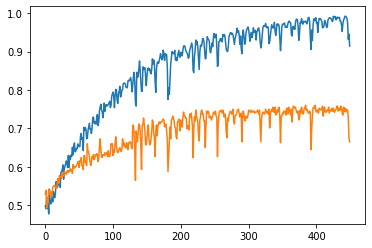

file= MatlabSpectrogram-harf/Spect_LOG_123_8910_harf+MatlabSpectrogram-kelime/Spect_LOG_123_8910_kelime, fold: f5, train score: 0.9793650507926941 test score: 0.7603092789649963 ,lr = 8e-06,
optimizer = <class 'keras.optimizers.Adam'>, act = softmax,extralayers= [<keras.layers.core.Dropout object at 0x7feeb7a91860>],batchsize=64


In [ ]:
 
for i in range(0, len(files_for_tuning)):
    folds = os.listdir(files_for_tuning[i])
    folds.sort()
    print("sorted: " ,folds)
    for model in models:
        for optimizer in opts:
            for act in acts:
                for loss in losses:
                    for lr in learning_rates:
                        for ep in epochs:
                          for extra_layers in extra_layers_array:
                              foldscore = 0
                              foldtrscore = 0
                              save_path=""
                              for j in range(0,len(folds)):   
                                  modeltmp = create_new_model(
                                      model, optimizer, lr, act, loss,
                                      tpu=False,extra_layers=extra_layers) 
                                  traingen1, testgen1,save_path =create_datagens(
                                          files_for_tuning[i] + "/" + folds[j],
                                          testAll=False,batch_size=batch_size)
                                  traingen2, testgen2,save_path =create_datagens(
                                          files_for_tuning[i+4] + "/" + folds[j],
                                          testAll=False,batch_size=batch_size)
                                  traingen,testgen =  TwoImageGenerator(traingen1,traingen2), TwoImageGenerator(testgen1,testgen2)
                                  checkpoint = ModelCheckpoint(
                                      save_path+"deney"+".h5",
                                      monitor='val_accuracy',
                                      verbose=1,
                                      save_best_only=True,
                                      mode='max',
                                      period=1)
                                   
                                  history = modeltmp.fit_generator(
                                                generator=traingen,
                                                steps_per_epoch=len(traingen), 
                                                validation_data=testgen,
                                                validation_steps=len(testgen),
                                                epochs=ep,
                                                use_multiprocessing=True,
                                                workers=0,
                                                verbose=1,
                                                callbacks=[])

                                  test = max(history.history["val_accuracy"])
                                  tr = history.history["accuracy"][
                                      history.history["val_accuracy"].index(
                                          test)]

                                  foldscore += test
                                  foldtrscore += tr
                                  plt.plot(history.history["accuracy"])
                                  plt.plot(history.history["val_accuracy"])
                                  plt.show()
                                  print(
                                      "file= {}+{}, fold: {}, train score: {} test score: {} ,lr = {},\noptimizer = {}, act = {},extralayers= {},batchsize={}".
                                      format(files_for_tuning[i],files_for_tuning[i+4], folds[j], tr, test,
                                            lr, optimizer,act,extra_layers,batch_size))


                            #print("General train performance: {}, test performance: {}".format(foldtrscore/5,foldscore/5))




# Testing Model and Printing Confusion Matrixes

In [ ]:
#PRINT CONFUSION MATRIX 
def GetCf(model, testgens):
    cf_sum = [[0,0],
              [0,0]] 
    for testgen in testgens:
      testgen.reset()
      Y_pred = model.predict_generator(testgen,
                                      testgen.n,verbose=1,workers=3)
      y_pred = np.argmax(Y_pred, axis=1) 
      cf_sum = cf_sum +   confusion_matrix(testgen.classes ,y_pred) 

    
    return cf_sum

def PrintCf(cf_sum):   
    target_names = ['Vigorous', 'Fatiguous']
    sns.set(font_scale=1.6) 
    ax = sns.heatmap(cf_sum, annot = True,linewidths=.5, xticklabels=target_names,yticklabels=target_names,cmap="YlGnBu",cbar=False, fmt='g')
    plt.show()
    
# Test Spectrogram Model with test dataset it belongs to      
# testAllFolds: If true, test all folds and print sum of their confusion matrixes 
# testCombined: Use model which trained with both letter and word datasets and test with both letter and word tests of current fold
def ManualTest(sType="BARK",sRange="12_910",fold="f2",voice="harf",testAllFolds=False,testCombined=False): 
  datasets = []
  folds = []
  Modelvoice=voice
  voices = [] 

  if (testCombined):
    Modelvoice ="harf+kelime"
    voices = ["harf","kelime"] 
  else:
    voices.append(voice)

  if(testAllFolds):
    folds = ["f1","f2","f3","f4","f5"] 
  else:
    folds.append(fold)   

  #Path of Dataset for testing
  cf = [[0,0],[0,0]]
  for fold in folds:

    
    #Combination prefix for Model
    prefixModel = sType+"_"+sRange+"_"+Modelvoice+"/"+fold
    
    #prefix with extension
    prefixWEx = prefixModel+".h5"
    print("Testing model: " + prefixModel + "...\n")

    #Path for h5
    savedModelPath = "Models/FVA_"+ prefixWEx
    #load model
    print("Loading model from : "+savedModelPath)
    modeltmp = load_model(savedModelPath, compile=False)
    print("Loaded model from : "+savedModelPath)

    datasets = []
    for voice in voices:
      prefixData = sType+"_"+sRange+"_"+voice+"/"+fold
      datasetPath = "MatlabSpectrogram-"+voice+"/"+"Spect_"+prefixData
      datasets.append(create_datagens(datasetPath,onlyTest=True)[1])
      print("Testing it with test data at: "+datasetPath)  
    cf = cf + GetCf(modeltmp,datasets)

  
  #Get Dataset by creating test data generator and test
  PrintCf(cf)          

Testing model: ERB_12_910_kelime/f1...

Loading model from : Models/FVA_ERB_12_910_kelime/f1.h5
Loaded model from : Models/FVA_ERB_12_910_kelime/f1.h5
Found 88 images belonging to 2 classes.
Testing it with test data at: MatlabSpectrogram-kelime/Spect_ERB_12_910_kelime/f1
88/88 [==============================] - 49s 559ms/step
Testing model: ERB_12_910_kelime/f2...

Loading model from : Models/FVA_ERB_12_910_kelime/f2.h5
Loaded model from : Models/FVA_ERB_12_910_kelime/f2.h5
Found 82 images belonging to 2 classes.
Testing it with test data at: MatlabSpectrogram-kelime/Spect_ERB_12_910_kelime/f2
82/82 [==============================] - 46s 559ms/step
Testing model: ERB_12_910_kelime/f3...

Loading model from : Models/FVA_ERB_12_910_kelime/f3.h5
Loaded model from : Models/FVA_ERB_12_910_kelime/f3.h5
Found 84 images belonging to 2 classes.
Testing it with test data at: MatlabSpectrogram-kelime/Spect_ERB_12_910_kelime/f3
84/84 [==============================] - 47s 554ms/step
Testing model

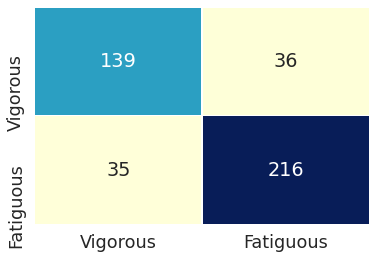

In [ ]:
ManualTest(sType="ERB",voice="kelime",testAllFolds=True,testCombined=False)

Not important, Use that if you want to change target names

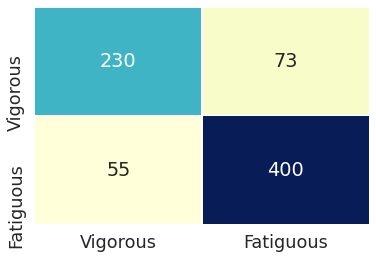

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
target_names = ['Vigorous', 'Fatiguous',]
binary = np.array([[230, 73],
                   [55, 400]])

ax = sns.heatmap(binary, annot = True,linewidths=.5, xticklabels=target_names,yticklabels=target_names,cmap="YlGnBu",cbar=False, fmt='g')
sns.set(font_scale=1.6) 
plt.show()

## Checking file counts for per classes on each folder to report 

In [ ]:
for folder in files:
  dinc = 0
  yorgun = 0
  for fold in os.listdir(folder):
    dinc   = dinc + len(os.listdir(folder  + "/"+fold+ "/Test/" + "dinc"))
    yorgun = yorgun + len(os.listdir(folder  + "/"+fold+ "/Test/" + "yorgun"))
  print(folder +", Dinc: ", dinc, " Yorgun: ",yorgun)
    

MatlabSpectrogram-harf/Spect_BARK_123_8910_harf, Dinc:  438  Yorgun:  396
MatlabSpectrogram-harf/Spect_BARK_12_910_harf, Dinc:  131  Yorgun:  197
MatlabSpectrogram-harf/Spect_BARK_1_10_harf, Dinc:  32  Yorgun:  87
MatlabSpectrogram-harf/Spect_ERB_123_8910_harf, Dinc:  438  Yorgun:  396
MatlabSpectrogram-harf/Spect_ERB_12_910_harf, Dinc:  131  Yorgun:  197
MatlabSpectrogram-harf/Spect_ERB_1_10_harf, Dinc:  32  Yorgun:  87
MatlabSpectrogram-harf/Spect_LOG_123_8910_harf, Dinc:  438  Yorgun:  396
MatlabSpectrogram-harf/Spect_LOG_12_910_harf, Dinc:  131  Yorgun:  197
MatlabSpectrogram-harf/Spect_LOG_1_10_harf, Dinc:  32  Yorgun:  87
MatlabSpectrogram-harf/Spect_MEL_123_8910_harf, Dinc:  438  Yorgun:  396
MatlabSpectrogram-harf/Spect_MEL_12_910_harf, Dinc:  131  Yorgun:  197
MatlabSpectrogram-harf/Spect_MEL_1_10_harf, Dinc:  32  Yorgun:  87
MatlabSpectrogram-kelime/Spect_BARK_123_8910_kelime, Dinc:  497  Yorgun:  428
MatlabSpectrogram-kelime/Spect_BARK_12_910_kelime, Dinc:  176  Yorgun:  254